<a href="https://colab.research.google.com/github/treiro/UNET-TGS-Fix/blob/main/TGS_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%ls

gdrive/  images/  masks/  model-tgs-salt.h5  sample_data/  train.zip


In [ ]:
%cp  gdrive/MyDrive/COLAB/Unet/train.zip  .

In [ ]:
! unzip train.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/d80ead8703.png   
  inflating: images/b012e9ebb0.png   
  inflating: images/d3034e7a60.png   
  inflating: images/ae2ef70d51.png   
  inflating: images/1af44a9db0.png   
  inflating: images/41cfd4b320.png   
  inflating: images/853e89d0d3.png   
  inflating: images/2a484baa26.png   
  inflating: images/92e617896e.png   
  inflating: images/b70f0ab0c2.png   
  inflating: images/e8757626a1.png   
  inflating: images/6a3d92ce59.png   
  inflating: images/127ef4105f.png   
  inflating: images/d21012f5c1.png   
  inflating: images/1cb9549d2c.png   
  inflating: images/e030bdae65.png   
  inflating: images/0cf7155eb6.png   
  inflating: images/badb3ea766.png   
  inflating: images/9bd58061d6.png   
  inflating: images/2b1e71c2a3.png   
  inflating: images/28d42de29f.png   
  inflating: images/10833853b3.png   
  inflating: images/ef13247eed.png   
  inflating: images/bce104494c.png   
  inflating: images/c8ce151a18.png   

In [ ]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [ ]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 3), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
print(X.shape)
print(y.shape)

(4000, 128, 128, 3)
(4000, 128, 128, 1)


#### Load the images and masks into arrays

In [ ]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    # img = load_img("images/"+id_, grayscale=True)
    # x_img = img_to_array(img)
    img = plt.imread("images/"+id_)
    
    # x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    x_img = resize(img,(128,128,3),mode = 'constant', preserve_range = True)
    
    # Load masks
    # mask = img_to_array(load_img("masks/"+id_, grayscale=True))
    mask = plt.imread("masks/"+id_)
    
    # mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    mask = resize(mask,(128,128, 1),mode = 'constant', preserve_range = True)
    
    # Save images
    # X[n] = x_img/255.0
    # y[n] = mask/255.0
    X[n] = x_img
    y[n] = mask
    # print(img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
print(X_train.shape)
print(y_train.shape)

(3600, 128, 128, 3)
(3600, 128, 128, 1)


#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'Salt')

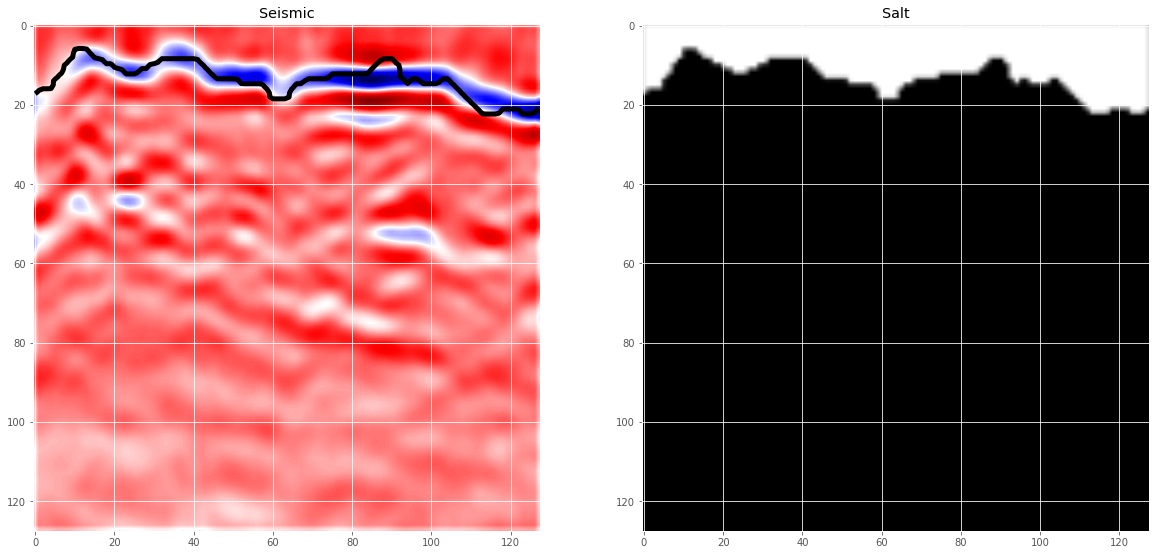

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator
# print(has_mask)
# print(y_train[ix].shape)
# print(y_train[ix].squeeze().shape)
# print('------------------------')
# print(X_train[ix].shape)
# print(X_train[ix, ..., 0].shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')

if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# input_img = Input((im_height, im_width, 1), name='img')
input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
113/113 [==============================] - 68s 128ms/step - loss: 0.4862 - accuracy: 0.7876 - val_loss: 1.7343 - val_accuracy: 0.4222

Epoch 00001: val_loss improved from inf to 1.73428, saving model to model-tgs-salt.h5
Epoch 2/50
113/113 [==============================] - 12s 103ms/step - loss: 0.3111 - accuracy: 0.8716 - val_loss: 1.5207 - val_accuracy: 0.5305

Epoch 00002: val_loss improved from 1.73428 to 1.52074, saving model to model-tgs-salt.h5
Epoch 3/50
113/113 [==============================] - 12s 103ms/step - loss: 0.2953 - accuracy: 0.8773 - val_loss: 0.9674 - val_accuracy: 0.7046

Epoch 00003: val_loss improved from 1.52074 to 0.96743, saving model to model-tgs-salt.h5
Epoch 4/50
113/113 [==============================] - 12s 104ms/step - loss: 0.2577 - accuracy: 0.8932 - val_loss: 0.5753 - val_accuracy: 0.8204

Epoch 00004: val_loss improved from 0.96743 to 0.57530, saving model to model-tgs-salt.h5
Epoch 5/50
113/113 [==============================] - 12s 10

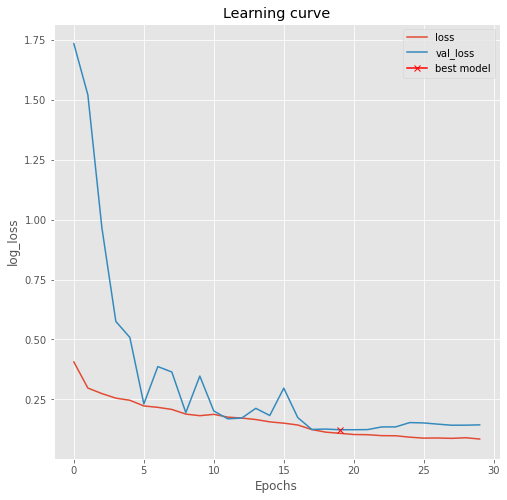

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [ ]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 0s 32ms/step - loss: 0.1233 - accuracy: 0.9471


[0.12334567308425903, 0.9470834136009216]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 0s 35ms/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

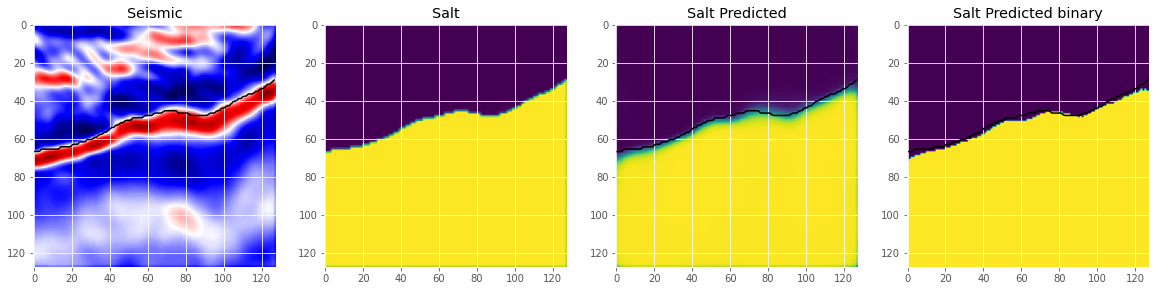

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

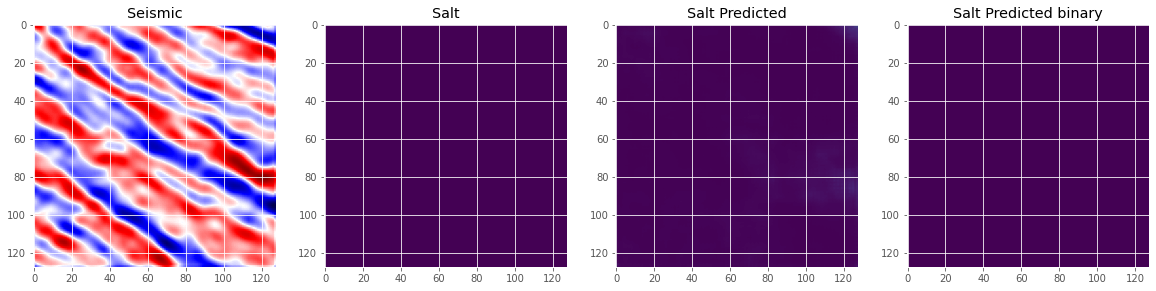

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

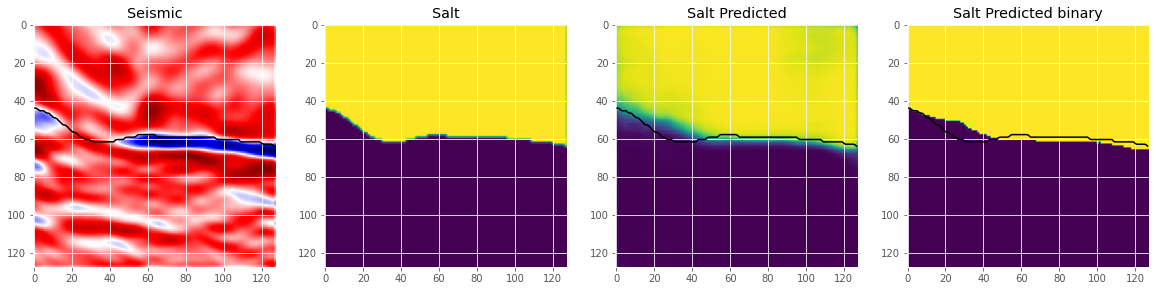

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

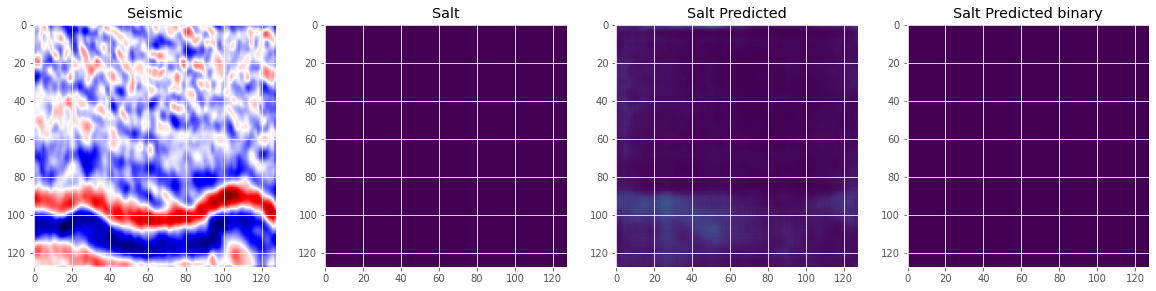

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

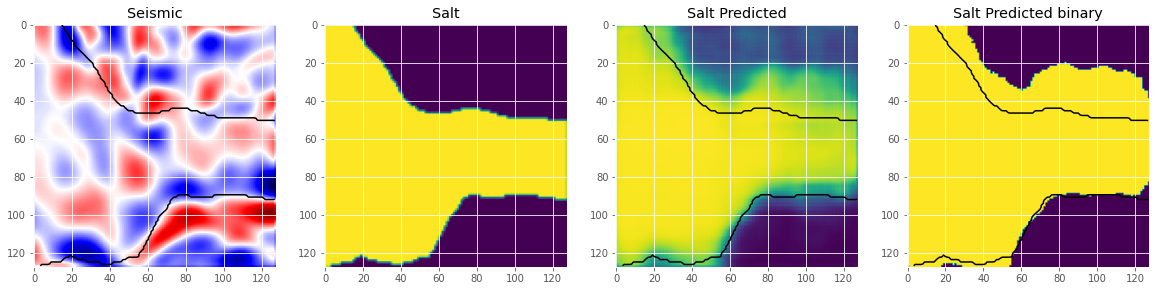

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

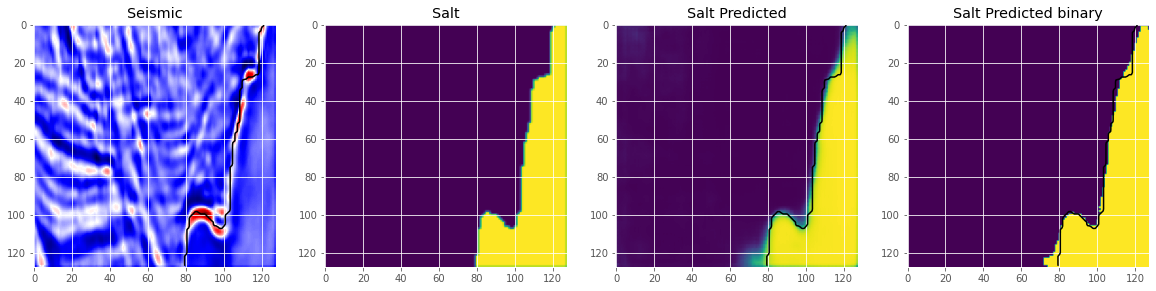

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

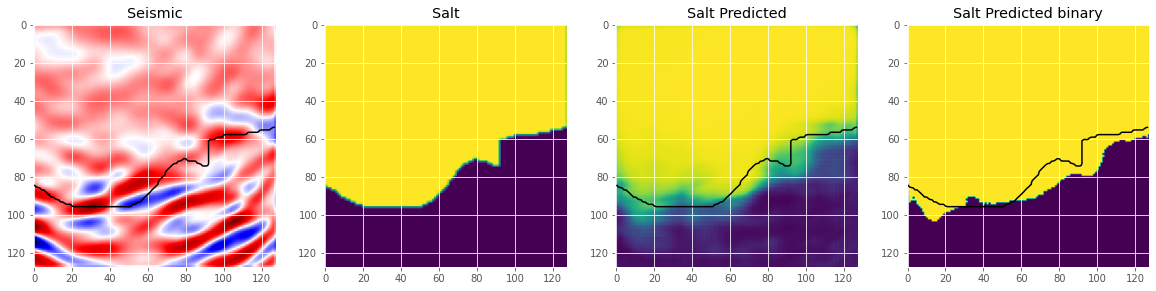

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

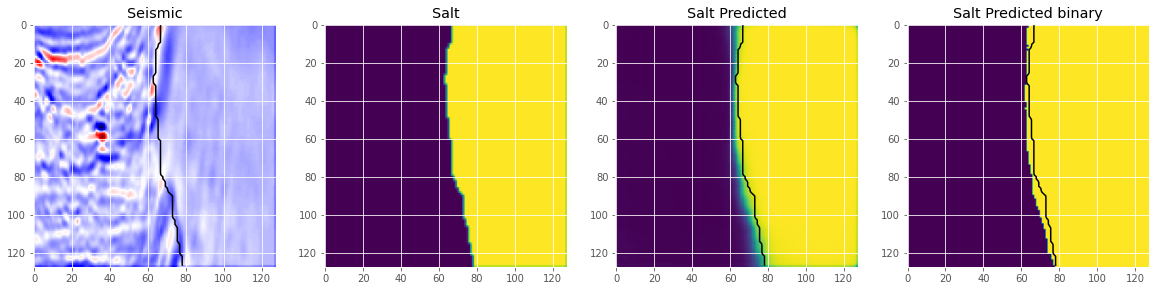

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

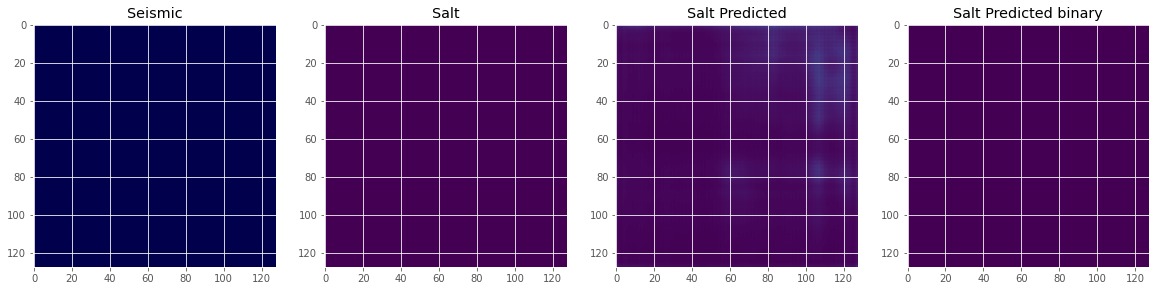

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

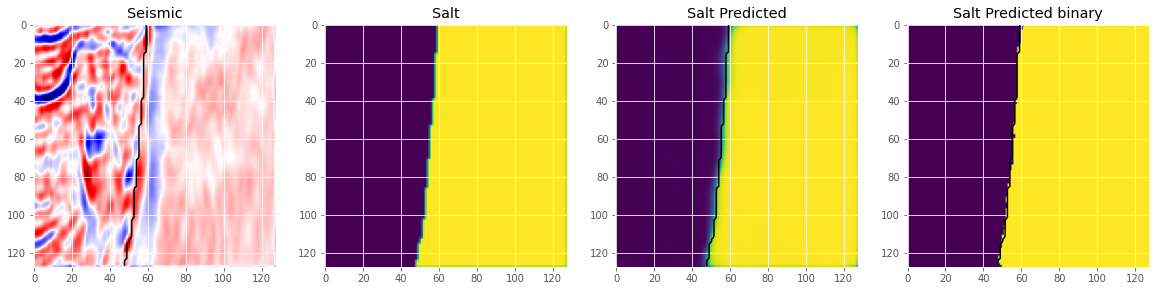

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

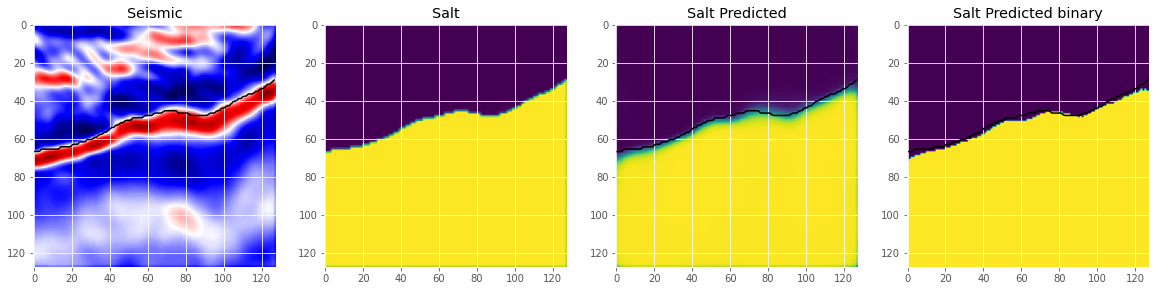

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

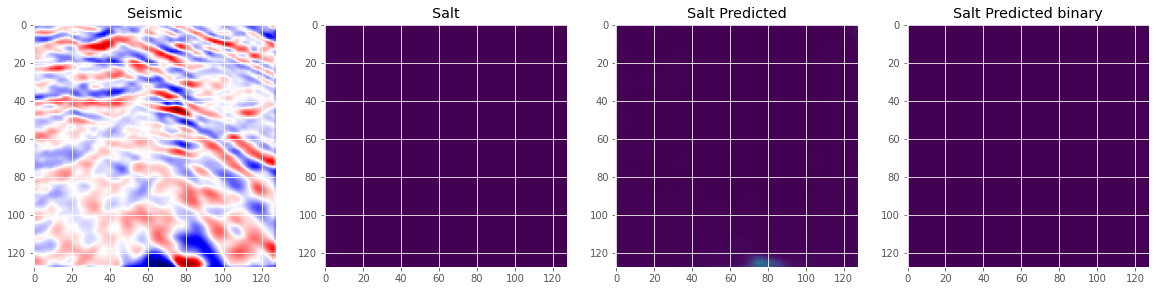

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

### Predictions on test set

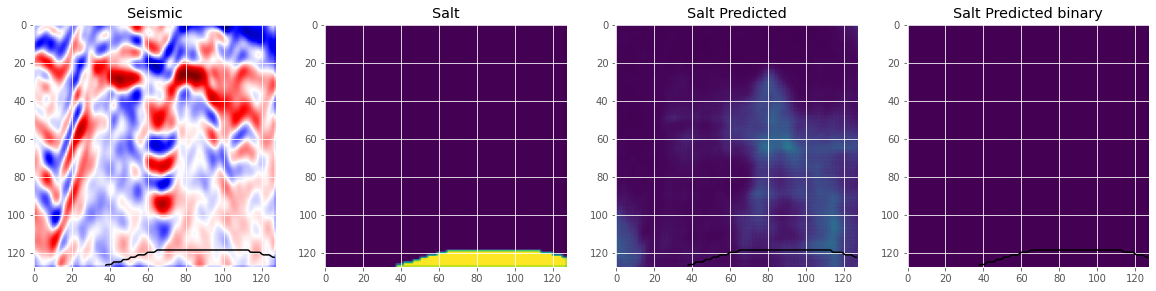

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

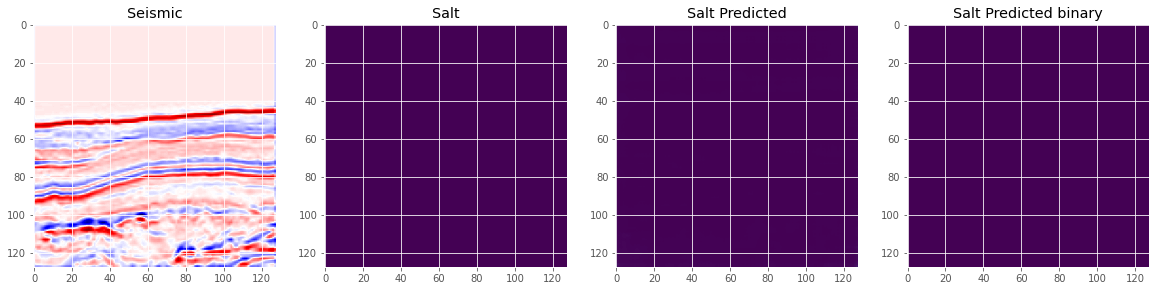

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

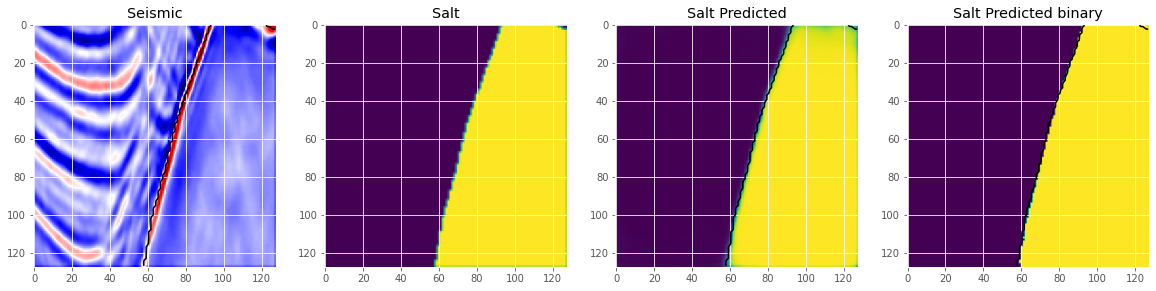

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

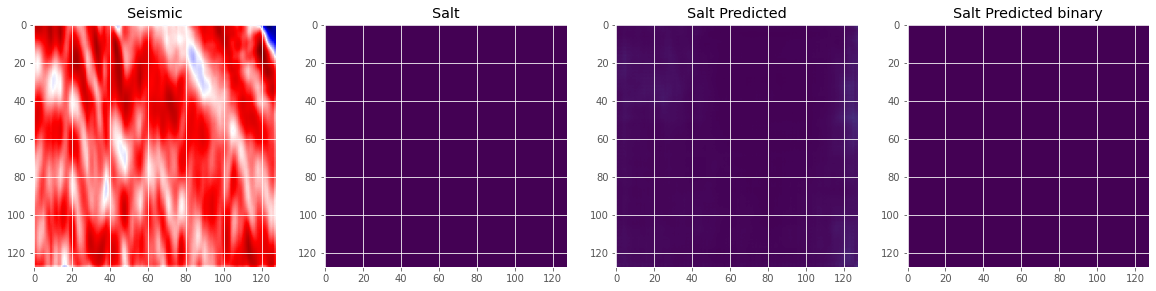

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

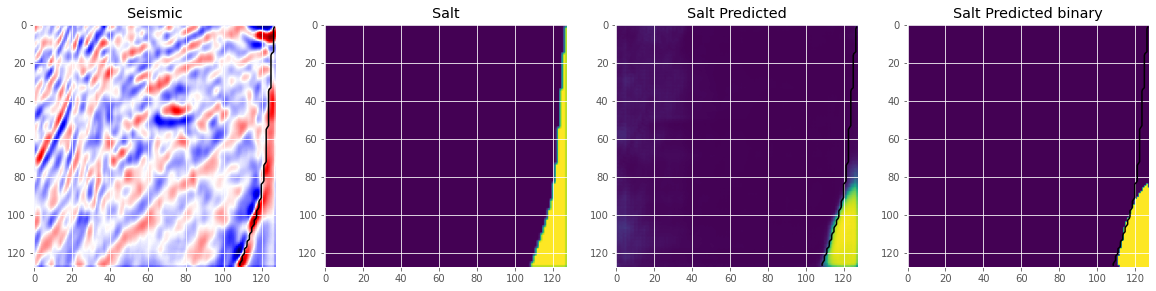

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

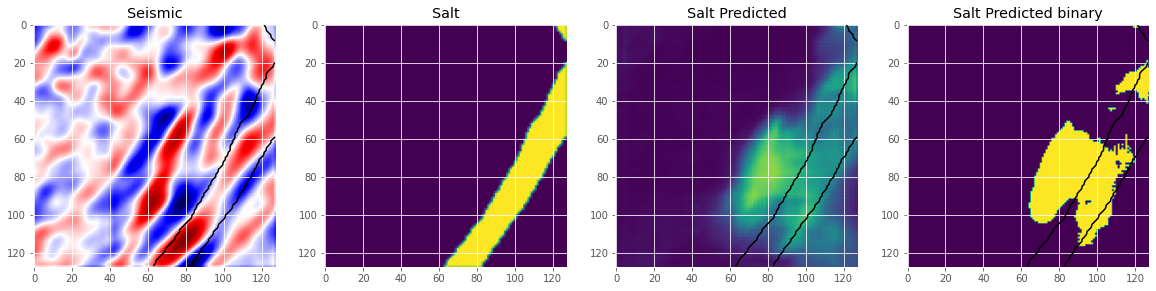

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

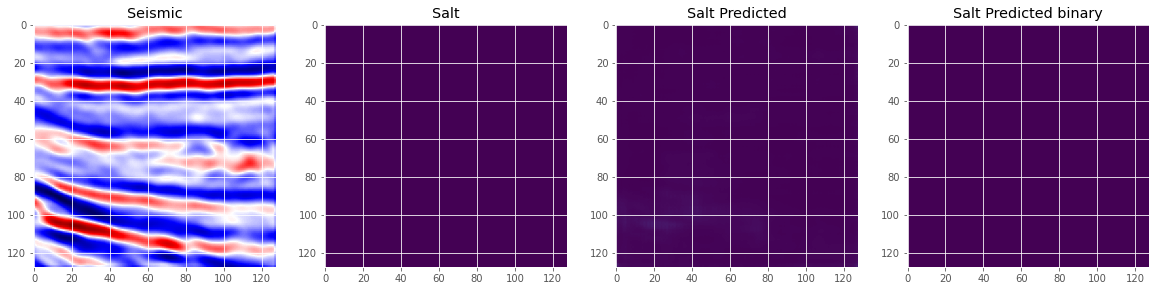

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

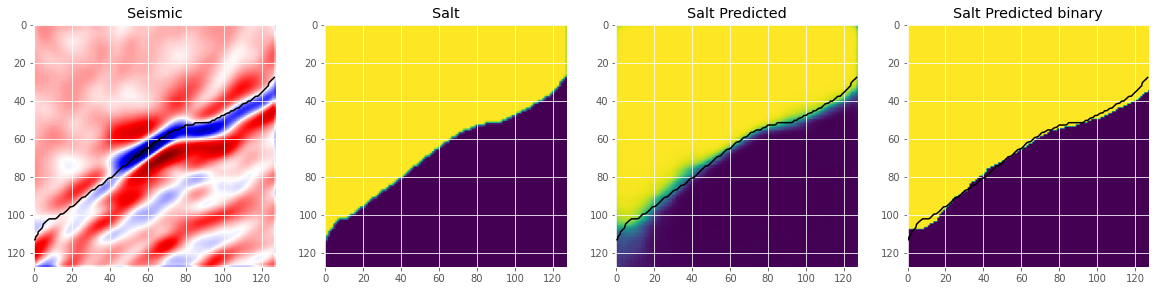

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

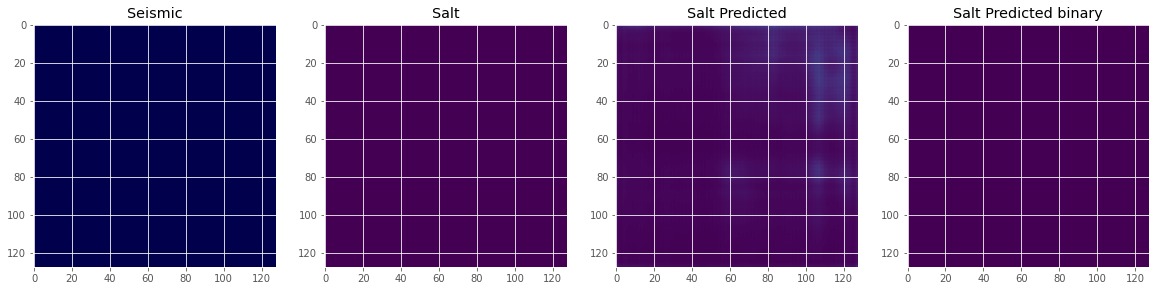

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

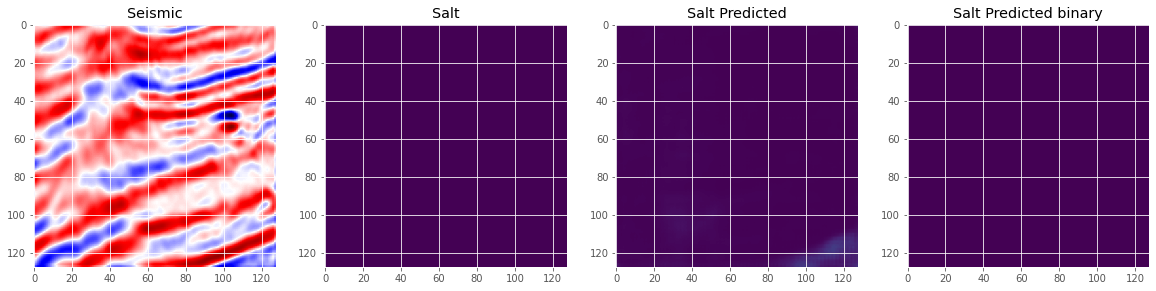

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

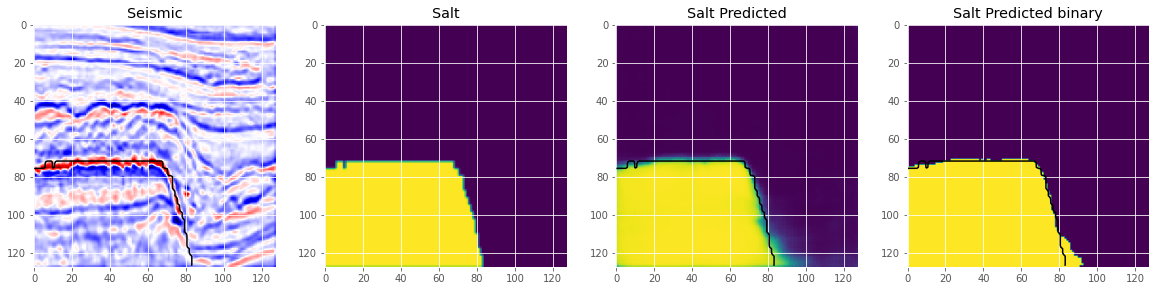

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

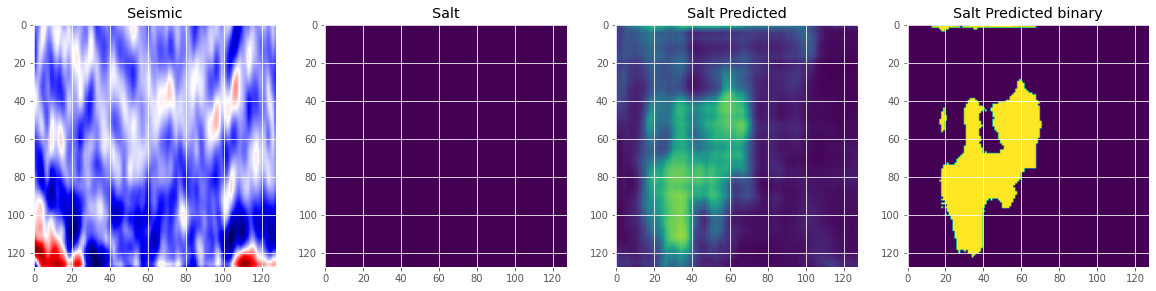

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

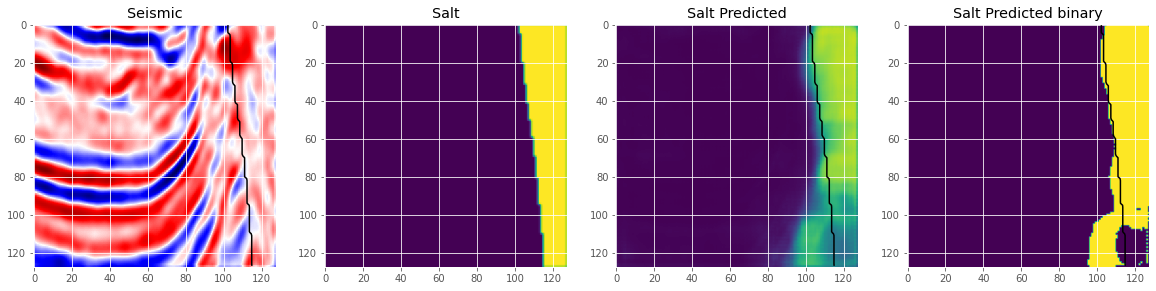

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

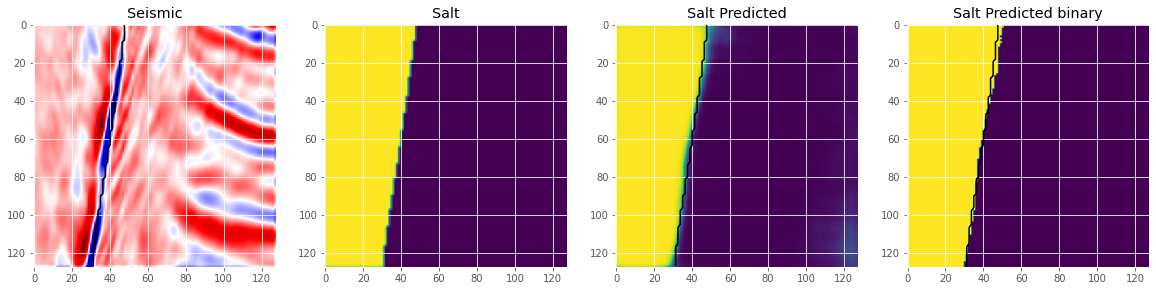

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

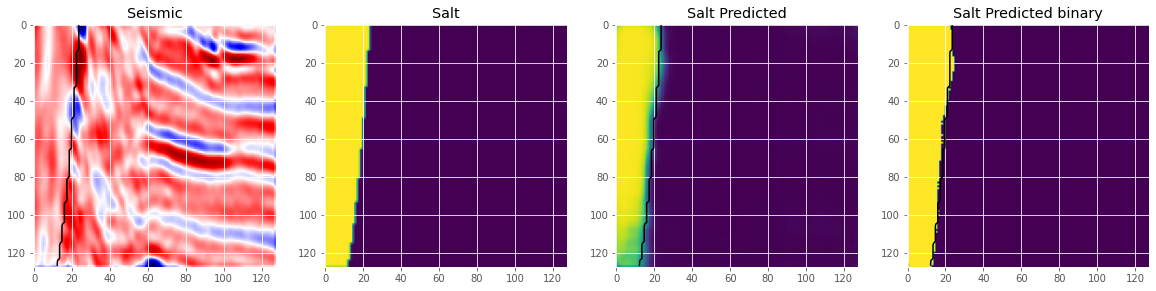

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

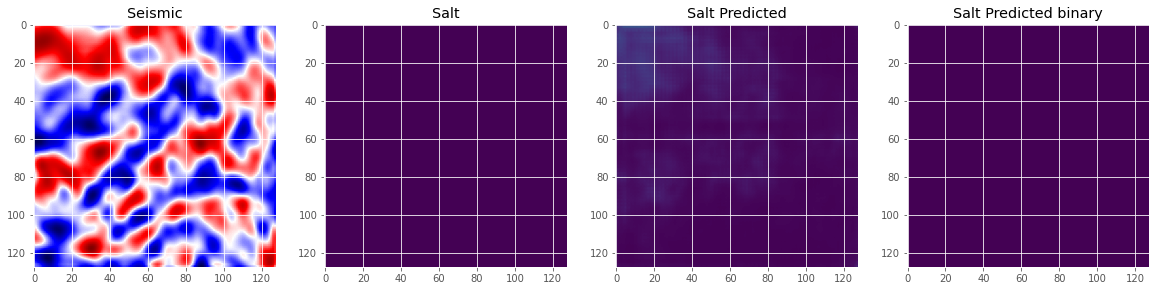

In [ ]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)